In [4]:
%%capture
%run 4.2_Self_Attention_Class.ipynb

In [18]:
# Manually Getting Weights:

queries = self_attn_v2.Wq(inputs)
keys = self_attn_v2.Wk(inputs)

attn_scores = queries @ keys.T
attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)

In [19]:
print("Attention Weights:\n\n", attn_weights)

Attention Weights:

 tensor([[0.1903, 0.1571, 0.1570, 0.1661, 0.1639, 0.1656],
        [0.1805, 0.1609, 0.1608, 0.1668, 0.1642, 0.1669],
        [0.1801, 0.1610, 0.1610, 0.1666, 0.1646, 0.1666],
        [0.1725, 0.1640, 0.1639, 0.1672, 0.1644, 0.1679],
        [0.1704, 0.1657, 0.1661, 0.1643, 0.1723, 0.1612],
        [0.1762, 0.1621, 0.1618, 0.1684, 0.1606, 0.1709]],
       grad_fn=<SoftmaxBackward0>)


<div align="center">
  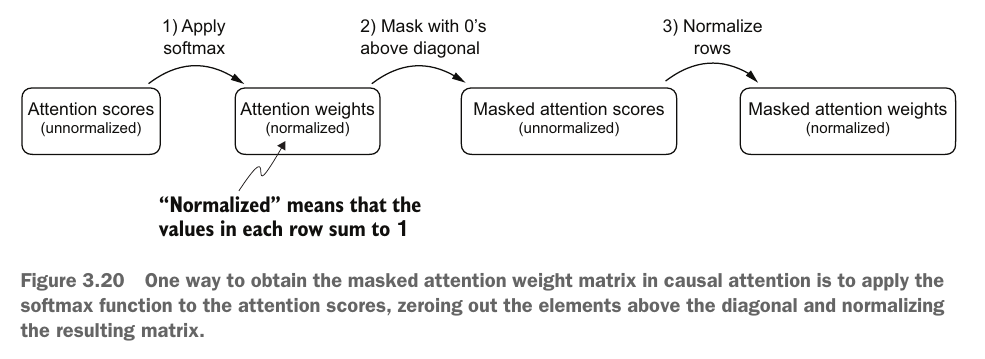
</div>

In [20]:
# Creating Mask

context_length = attn_scores.shape[0] # 6
mask_simple = torch.tril(torch.ones(context_length, context_length))

In [21]:
print("Mask Simple:\n\n", mask_simple)

Mask Simple:

 tensor([[1., 0., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0., 0.],
        [1., 1., 1., 0., 0., 0.],
        [1., 1., 1., 1., 0., 0.],
        [1., 1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1., 1.]])


In [22]:
# Getting Masked Scores and Normalizing Again:

maskeds_scores = attn_weights * mask_simple
maskeds_weights = maskeds_scores / maskeds_scores.sum(dim=-1, keepdim=True)

In [24]:
print("Simple Masked Scores:\n\n", maskeds_scores, end="\n\n")
print("Simple Masked Weights:\n\n", maskeds_weights)

Simple Masked Scores:

 tensor([[0.1903, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.1805, 0.1609, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.1801, 0.1610, 0.1610, 0.0000, 0.0000, 0.0000],
        [0.1725, 0.1640, 0.1639, 0.1672, 0.0000, 0.0000],
        [0.1704, 0.1657, 0.1661, 0.1643, 0.1723, 0.0000],
        [0.1762, 0.1621, 0.1618, 0.1684, 0.1606, 0.1709]],
       grad_fn=<MulBackward0>)

Simple Masked Weights:

 tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5287, 0.4713, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3587, 0.3207, 0.3206, 0.0000, 0.0000, 0.0000],
        [0.2583, 0.2457, 0.2456, 0.2504, 0.0000, 0.0000],
        [0.2031, 0.1976, 0.1980, 0.1959, 0.2054, 0.0000],
        [0.1762, 0.1621, 0.1618, 0.1684, 0.1606, 0.1709]],
       grad_fn=<DivBackward0>)


<div align="center">
  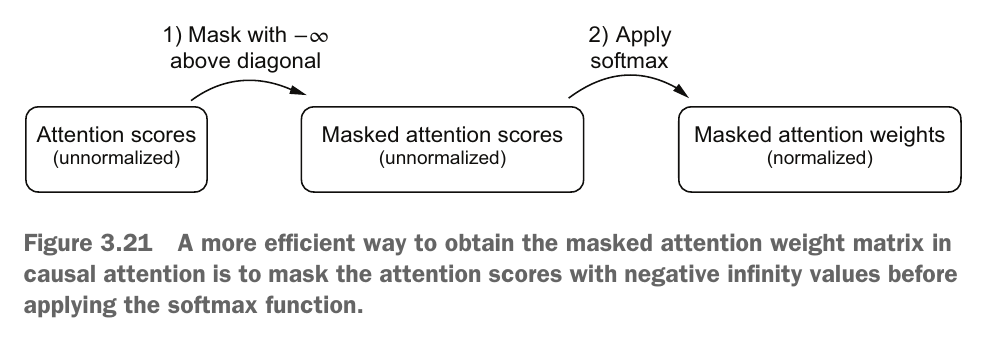
</div>

In [25]:
# Masking with 1's Above the Diagonal and Replacing the 1's with -inf

mask = torch.triu(torch.ones(context_length, context_length), diagonal=1)

In [26]:
print("Mask:\n\n", mask)

Mask:

 tensor([[0., 1., 1., 1., 1., 1.],
        [0., 0., 1., 1., 1., 1.],
        [0., 0., 0., 1., 1., 1.],
        [0., 0., 0., 0., 1., 1.],
        [0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0.]])


In [27]:
masked_scores = attn_scores.masked_fill(mask.bool(), -torch.inf)
masked_weights = torch.softmax(masked_scores / keys.shape[-1]**0.5, dim=1)

In [33]:
print("Masked Scores:\n\n", masked_scores, end="\n\n")
print("Masked Weights:\n\n", masked_weights)

Masked Scores:

 tensor([[ 0.0425,    -inf,    -inf,    -inf,    -inf,    -inf],
        [ 0.0210, -0.1418,    -inf,    -inf,    -inf,    -inf],
        [ 0.0220, -0.1366, -0.1370,    -inf,    -inf,    -inf],
        [ 0.0034, -0.0674, -0.0683, -0.0405,    -inf,    -inf],
        [ 0.0346, -0.0043, -0.0014, -0.0164,  0.0508,    -inf],
        [-0.0055, -0.1238, -0.1264, -0.0697, -0.1366, -0.0493]],
       grad_fn=<MaskedFillBackward0>)

Masked Weights:

 tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5287, 0.4713, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3587, 0.3207, 0.3206, 0.0000, 0.0000, 0.0000],
        [0.2583, 0.2457, 0.2456, 0.2504, 0.0000, 0.0000],
        [0.2031, 0.1976, 0.1980, 0.1959, 0.2054, 0.0000],
        [0.1762, 0.1621, 0.1618, 0.1684, 0.1606, 0.1709]],
       grad_fn=<SoftmaxBackward0>)


In [41]:
# Dropout:

torch.manual_seed(666)

dropout = torch.nn.Dropout(0.5)
example = torch.ones(6, 6)

In [42]:
print("Pre-Dropout:\n\n", example, end="\n\n")
print("Post-Dropout:\n\n", dropout(example))

Pre-Dropout:

 tensor([[1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1.]])

Post-Dropout:

 tensor([[2., 0., 0., 0., 0., 2.],
        [2., 0., 0., 0., 2., 2.],
        [2., 2., 0., 2., 2., 2.],
        [2., 2., 0., 0., 2., 2.],
        [0., 0., 2., 0., 0., 2.],
        [2., 0., 2., 0., 2., 0.]])


In [43]:
print("Masked Attention Weights after Dropout:\n\n", dropout(masked_weights))

Masked Attention Weights after Dropout:

 tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.7175, 0.6414, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.4914, 0.0000, 0.5008, 0.0000, 0.0000],
        [0.4062, 0.3952, 0.3960, 0.3918, 0.4109, 0.0000],
        [0.0000, 0.3242, 0.0000, 0.3368, 0.0000, 0.3417]],
       grad_fn=<MulBackward0>)
